# Example Lasso gLV model

In [1]:
from mimic.utilities.utilities import *
from mimic.model_infer.infer_gLV_bayes import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

(3, 100, 5)
[28.88248428 46.93130458 16.82105576 38.67933238 44.87209099]
minimum found: a/error: [1.29154967e-03 1.00000000e-09] 0.09196601176191062
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [1.3270918724624219, 0.6434593659409151, 1.878893955402427, 0.8597855899687001, 0.8915024867127366], 'M': [[-0.053860757051265626, 0.0017940302826897423, -0.02351140030037711, -0.0010925577901253981, 0.001766638817205914], [0.0, -0.08985050006840202, -0.007911392517321557, 0.0442363991759798, 0.004590307004271697], [-0.0021297621140682647, 0.0006375198319532151, -0.13432230162469302, -0.0003385552274904023, 0.0018377092669786441], [0.0, -0.00010594551152418524, -0.0009724471160910383, -0.009743895694186036, 0.0], [0.0, 0.007257662703460285, -0.019106700711422665, -0.0022878156013554983, -0.14486771497608295]], 'epsilon': array([], shape=(5, 0), dtype=float64)}
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [1.3270918724624219, 0.643459

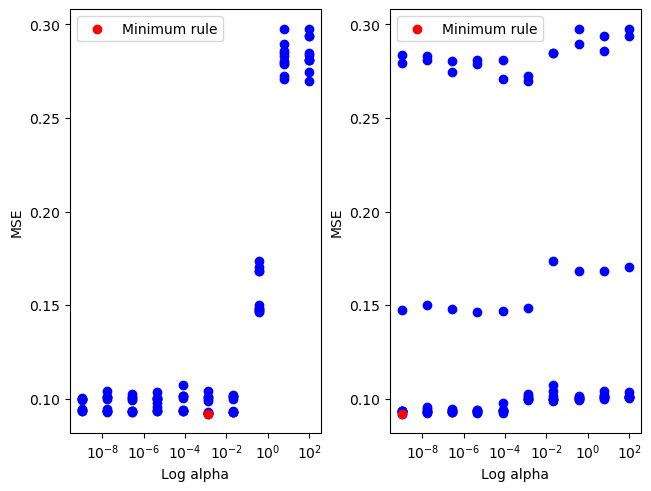

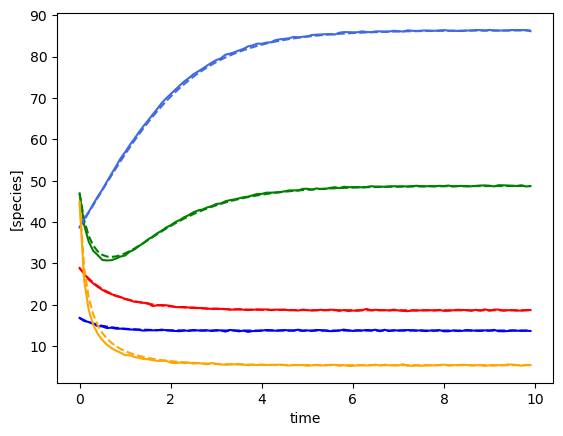

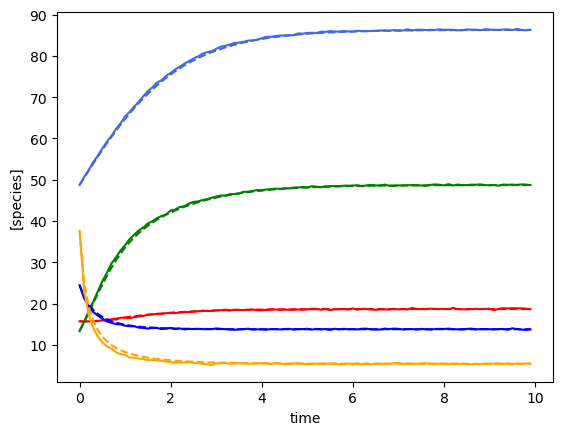

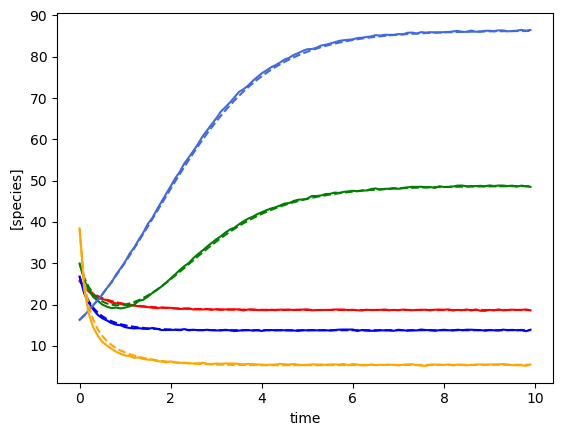

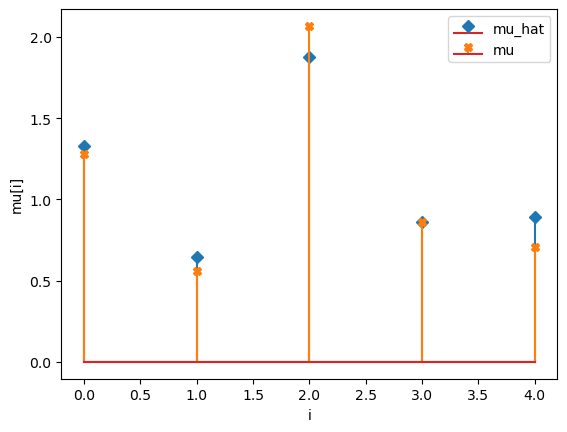

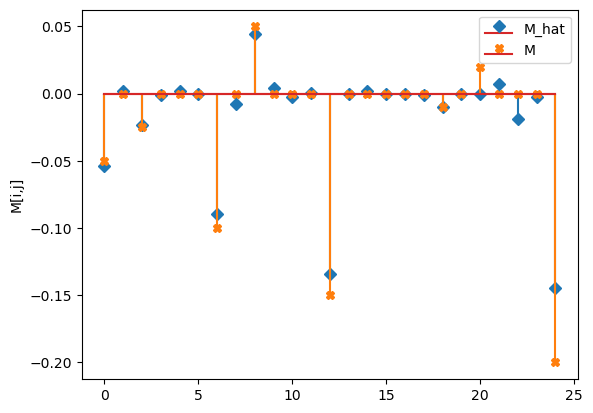

In [4]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])
print(ryobs.shape)
print(ryobs[0,0,:])

X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])


alphas = fit_alpha_MPLasso(X, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(X, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][:num_species].tolist() for i in range(0, num_species)]

predictor = sim_gLV(num_species=num_species, M=M_h, mu=mu_h)

# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:])
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))